Using device: cuda


Ours Pendulum-v1:   0%|          | 0/50 [00:00<?, ?ep/s]

Ours MountainCarContinuous-v0:   0%|          | 0/50 [00:00<?, ?ep/s]

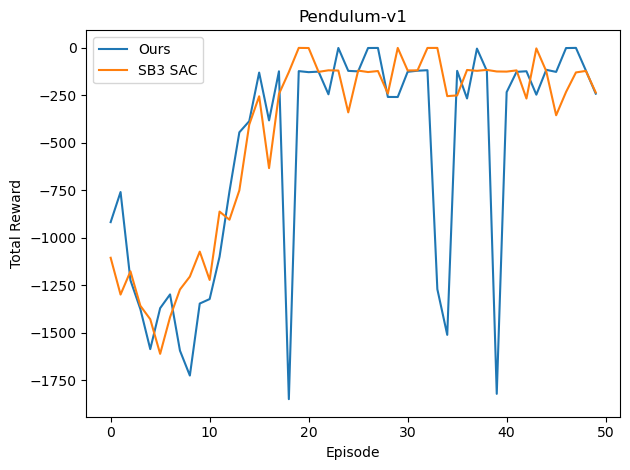

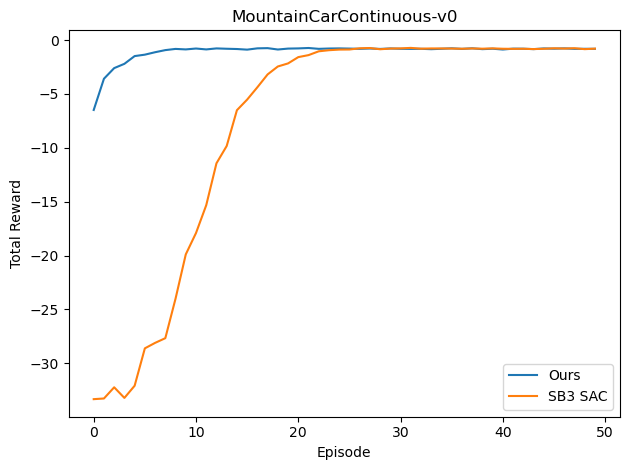

In [3]:
#!/usr/bin/env python3
import random
import numpy as np
import torch
import gym                             # our SAC uses gym
import gymnasium as gym_sb3           # SB3 SAC uses gymnasium
import torch.nn as nn
import torch.optim as optim
import math
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from stable_baselines3 import SAC as SB3_SAC
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import BaseCallback

# --------------------------------------------------------------------------- #
# Fix all seeds
# --------------------------------------------------------------------------- #
base_seed = 12345
random.seed(base_seed)
np.random.seed(base_seed)
torch.manual_seed(base_seed)
torch.cuda.manual_seed_all(base_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark     = False

# --------------------------------------------------------------------------- #
# Device
# --------------------------------------------------------------------------- #
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# --------------------------------------------------------------------------- #
# Replay Buffer (CPU storage, GPU sampling)
# --------------------------------------------------------------------------- #
class ReplayBuffer:
    def __init__(self, capacity, obs_dim, act_dim):
        self.capacity = capacity
        self.obs_buf      = np.zeros((capacity, obs_dim),      np.float32)
        self.next_obs_buf = np.zeros((capacity, obs_dim),      np.float32)
        self.acts_buf     = np.zeros((capacity, act_dim),      np.float32)
        self.rews_buf     = np.zeros((capacity,),              np.float32)
        self.done_buf     = np.zeros((capacity,),              np.float32)
        self.ptr, self.size = 0, 0

    def push(self, obs, act, rew, next_obs, done):
        self.obs_buf[self.ptr]      = obs
        self.acts_buf[self.ptr]     = act
        self.rews_buf[self.ptr]     = rew
        self.next_obs_buf[self.ptr] = next_obs
        self.done_buf[self.ptr]     = done
        self.ptr = (self.ptr + 1) % self.capacity
        self.size = min(self.size + 1, self.capacity)

    def sample(self, batch_size):
        idxs = np.random.randint(0, self.size, size=batch_size)
        return {
            'obs':      torch.tensor(self.obs_buf[idxs],      device=device),
            'actions':  torch.tensor(self.acts_buf[idxs],     device=device),
            'rewards':  torch.tensor(self.rews_buf[idxs],     device=device).unsqueeze(-1),
            'next_obs': torch.tensor(self.next_obs_buf[idxs], device=device),
            'dones':    torch.tensor(self.done_buf[idxs],     device=device).unsqueeze(-1),
        }

    def __len__(self):
        return self.size

# --------------------------------------------------------------------------- #
# Our SAC Implementation — with Tanh‐Jacobian correction
# --------------------------------------------------------------------------- #
class Actor(nn.Module):
    def __init__(self, obs_dim, act_dim, hidden=(256,256)):
        super().__init__()
        layers, last = [], obs_dim
        for h in hidden:
            layers += [nn.Linear(last, h), nn.ReLU()]
            last = h
        self.net           = nn.Sequential(*layers)
        self.mu_layer      = nn.Linear(last, act_dim)
        self.log_std_layer = nn.Linear(last, act_dim)

    def forward(self, x):
        h = self.net(x)
        mu      = self.mu_layer(h)
        log_std = self.log_std_layer(h).clamp(-20, 2)
        std     = torch.exp(log_std)
        return mu, log_std, std

    def sample(self, x):
        mu, log_std, std = self.forward(x)
        eps      = torch.randn_like(mu)
        pre_tanh = mu + eps * std

        # Gaussian log‐prob
        gauss_logp = -0.5 * (
            ((pre_tanh - mu) / std)**2
            + 2 * log_std
            + math.log(2 * math.pi)
        )
        gauss_logp = gauss_logp.sum(-1, keepdim=True)

        # Tanh transformation
        action = torch.tanh(pre_tanh)
        # Correction term: log |d tanh(u)/du| = sum log(1 - tanh(u)^2)
        # stable form: 2*(log 2 - u - softplus(-2u))
        log_det = 2 * (math.log(2) - pre_tanh - nn.functional.softplus(-2 * pre_tanh))
        logp = gauss_logp - log_det.sum(-1, keepdim=True)

        return action, logp

class Critic(nn.Module):
    def __init__(self, obs_dim, act_dim, hidden=(256,256)):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim + act_dim, hidden[0]), nn.ReLU(),
            nn.Linear(hidden[0], hidden[1]),         nn.ReLU(),
            nn.Linear(hidden[1], 1),
        )
    def forward(self, x, a):
        return self.net(torch.cat([x, a], -1))

class SACAgent:
    def __init__(self, obs_dim, act_dim,
                 reward_scale=1.0,
                 actor_lr=3e-4, critic_lr=3e-4, alpha_lr=3e-4,
                 discount=0.99, tau=0.005,
                 auto_entropy=True, target_entropy=None):
        # nets + targets
        self.actor   = Actor(obs_dim, act_dim).to(device)
        self.critic1 = Critic(obs_dim, act_dim).to(device)
        self.critic2 = Critic(obs_dim, act_dim).to(device)
        self.targ1   = Critic(obs_dim, act_dim).to(device)
        self.targ2   = Critic(obs_dim, act_dim).to(device)
        self.targ1.load_state_dict(self.critic1.state_dict())
        self.targ2.load_state_dict(self.critic2.state_dict())

        # optimizers
        self.a_opt  = optim.Adam(self.actor.parameters(),  lr=actor_lr)
        self.q1_opt = optim.Adam(self.critic1.parameters(), lr=critic_lr)
        self.q2_opt = optim.Adam(self.critic2.parameters(), lr=critic_lr)

        # entropy α
        self.auto_entropy = auto_entropy
        if auto_entropy:
            self.log_alpha = torch.zeros(1, requires_grad=True, device=device)
            self.alpha_opt = optim.Adam([self.log_alpha], lr=alpha_lr)
            self.target_entropy = -act_dim if target_entropy is None else target_entropy
        else:
            self._alpha = 1.0

        # other hyperparams
        self.discount = discount
        self.tau      = tau
        self.scale    = reward_scale
        self.mse      = nn.MSELoss()

    @property
    def alpha(self):
        return self.log_alpha.exp() if self.auto_entropy else torch.tensor(self._alpha, device=device)

    def soft_update(self):
        for src, tgt in [(self.critic1, self.targ1), (self.critic2, self.targ2)]:
            for p, tp in zip(src.parameters(), tgt.parameters()):
                tp.data.copy_(self.tau * p.data + (1 - self.tau) * tp.data)

    def update(self, batch):
        o, a = batch['obs'], batch['actions']
        r, o2, d = batch['rewards'], batch['next_obs'], batch['dones']

        # 1) Critic targets
        with torch.no_grad():
            a2, logp2 = self.actor.sample(o2)
            q2_min = torch.min(self.targ1(o2, a2), self.targ2(o2, a2))
            target_q = self.scale * r + (1 - d) * self.discount * (q2_min - self.alpha * logp2)

        # 2) Critic losses
        loss_q1 = self.mse(self.critic1(o, a), target_q)
        loss_q2 = self.mse(self.critic2(o, a), target_q)
        self.q1_opt.zero_grad(); loss_q1.backward(); self.q1_opt.step()
        self.q2_opt.zero_grad(); loss_q2.backward(); self.q2_opt.step()

        # 3) Actor loss
        a_new, logp = self.actor.sample(o)
        qn = torch.min(self.critic1(o, a_new), self.critic2(o, a_new))
        loss_pi = (self.alpha * logp - qn).mean()
        self.a_opt.zero_grad(); loss_pi.backward(); self.a_opt.step()

        # 4) Alpha loss
        if self.auto_entropy:
            loss_alpha = -(self.log_alpha * (logp + self.target_entropy).detach()).mean()
            self.alpha_opt.zero_grad(); loss_alpha.backward(); self.alpha_opt.step()
        else:
            loss_alpha = torch.tensor(0., device=device)

        # 5) Soft‐update targets
        self.soft_update()

        return loss_q1.item(), loss_q2.item(), loss_pi.item(), loss_alpha.item(), self.alpha.item()

# --------------------------------------------------------------------------- #
# Train our SAC — with env‐specific tweaks
# --------------------------------------------------------------------------- #
def train_ours(env_id, episodes, batch_size, reward_scale, grad_steps=1, prefill=0):
    env = gym.make(env_id)
    env.seed(base_seed); env.action_space.seed(base_seed)

    max_steps = getattr(env, "_max_episode_steps", env.spec.max_episode_steps)
    obs_dim, act_dim = env.observation_space.shape[0], env.action_space.shape[0]
    agent = SACAgent(obs_dim, act_dim, reward_scale=reward_scale)
    buf   = ReplayBuffer(int(1e6), obs_dim, act_dim)

    # 1) Prefill replay buffer with random for initial stability
    if prefill > 0:
        o = env.reset()
        for _ in range(prefill):
            a = env.action_space.sample()
            n, r, d, _ = env.step(a)
            buf.push(o, np.array(a).reshape(-1), r, n, float(d))
            o = n if not d else env.reset()

    returns = []
    for ep in tqdm(range(episodes), desc=f"Ours {env_id}", unit="ep"):
        o, tot = env.reset(), 0.0
        for _ in range(max_steps):
            o_t = torch.tensor(o, dtype=torch.float32, device=device).unsqueeze(0)
            with torch.no_grad():
                a, _ = agent.actor.sample(o_t)
            a_np = (a[0].cpu().numpy() * float(env.action_space.high[0]))
            n, r, d, _ = env.step(a_np)
            buf.push(o, np.array(a_np).reshape(-1), r, n, float(d))
            # do multiple gradient steps
            if len(buf) > batch_size:
                for _ in range(grad_steps):
                    agent.update(buf.sample(batch_size))
            o, tot = n, tot + r
            if d: break
        returns.append(tot)
    return returns

# --------------------------------------------------------------------------- #
# SB3 callback to record returns
# --------------------------------------------------------------------------- #
class EpisodeRewardLogger(BaseCallback):
    def __init__(self):
        super().__init__()
        self.rewards = []
    def _on_step(self) -> bool:
        for info in self.locals.get("infos", []):
            if "episode" in info:
                self.rewards.append(info["episode"]["r"])
        return True

def train_sb3(env_id, episodes):
    # use gymnasium so action_space is gymnasium.spaces.Box
    env0   = gym_sb3.make(env_id)
    env_sb3= Monitor(env0)
    env_sb3.reset(seed=base_seed)
    env_sb3.action_space.seed(base_seed)

    max_steps = getattr(env_sb3.env, "_max_episode_steps", env_sb3.env.spec.max_episode_steps)
    total_ts  = episodes * max_steps

    model  = SB3_SAC("MlpPolicy", env_sb3, verbose=0, seed=base_seed, device=device)
    logger = EpisodeRewardLogger()
    model.learn(total_timesteps=total_ts, callback=logger)
    return logger.rewards[:episodes]

# --------------------------------------------------------------------------- #
# Main: one figure per env
# --------------------------------------------------------------------------- #
def main():
    configs = [
        # env_id, episodes, batch_size, reward_scale, grad_steps, prefill
        ("Pendulum-v1",              50,  256,   1.0,   1,    1000),
        ("MountainCarContinuous-v0", 50, 256, 100.0,   1,   10000),
    ]
    for env_id, eps, bs, rs, gs, pf in configs:
        ours = train_ours(env_id, eps, bs, rs, grad_steps=gs, prefill=pf)
        sb3  = train_sb3(env_id, eps)

        plt.figure()
        plt.plot(ours, label="Ours")
        plt.plot(sb3,  label="SB3 SAC")
        plt.xlabel("Episode")
        plt.ylabel("Total Reward")
        plt.title(env_id)
        plt.legend()
        plt.tight_layout()

    plt.show()

if __name__ == "__main__":
    main()
